# The Margin Matters

Allen Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf

## Tracking Congress

If you Google "Republican Congress backbone", you will get a lot of answers to the same question: "Why do Republicans in Congress vote with Donald Trump, even when his policies conflict with long-standing Republican principles?

[This example from *The New York Times*](https://www.nytimes.com/2020/02/05/opinion/trump-senate-acquittal-impeachment.html) suggests it comes down to fear of reprisal from Trump, the party leadership, the conservative media, and social media.

At the same time, when pundits are asked to explain a vote from a particular member of Congress, they often start with something like, "So-and-so represents a district that voted for Trump by a 20% margin..."

So that makes me wonder: if members of Congress are voting out of fear, to what degree are they afraid of their constituents?

It seems like our friends at FiveThirtyEight have thought about the same question, because they publish "An updating tally of how often every member of the House and the Senate votes with or against the president": 

* [Tracking Congress In The Age Of Trump](https://projects.fivethirtyeight.com/congress-trump-score/?ex_cid=rrpromo)

The table there includes every member of the 115th and 116th Congresses who cast a vote; it reports Trump's margin of victory in the region they represent and the fraction of votes they cast that agree with Trump (they explain how they determined that).

I'll use their data to explore the relationship between these voting patterns and Trump's margin victory.

In [2]:
# Load the data file

import os

if not os.path.exists('averages.csv'):
    !wget https://projects.fivethirtyeight.com/congress-tracker-data/csv/averages.csv

Here's what the dataset looks like.

In [3]:
df = pd.read_csv('averages.csv')
df.head()

,congress,chamber,bioguide,last_name,state,district,party,votes,agree_pct,predicted_agree,net_trump_vote
0,0,house,A000055,Aderholt,AL,4.0,Republican,164.0,0.975610,0.957037,63.0
1,115,house,A000055,Aderholt,AL,4.0,R,95.0,0.968421,0.946349,63.0
2,116,house,A000055,Aderholt,AL,4.0,R,69.0,0.985507,0.971751,63.0
3,0,house,A000367,Amash,MI,3.0,Independent,163.0,0.638037,0.753716,9.4
4,115,house,A000367,Amash,MI,3.0,R,96.0,0.541667,0.847386,9.4


I'll select the rows with `congress==0`, which is the sum of votes from the 115th and 116th Congresses.

In [4]:
both_sessions = (df['congress'] == 0)
df_all = df.loc[both_sessions].copy()
df_all.head()

,congress,chamber,bioguide,last_name,state,district,party,votes,agree_pct,predicted_agree,net_trump_vote
0,0,house,A000055,Aderholt,AL,4.0,Republican,164.0,0.975610,0.957037,63.0
3,0,house,A000367,Amash,MI,3.0,Independent,163.0,0.638037,0.753716,9.4
7,0,house,A000369,Amodei,NV,2.0,Republican,164.0,0.969512,0.808592,12.3
10,0,house,A000370,Adams,NC,12.0,Democrat,163.0,0.116564,0.135310,-40.0
13,0,house,A000371,Aguilar,CA,31.0,Democrat,164.0,0.182927,0.206453,-21.1


## Log odds

Since the dependent variable is a percentage, I will transform it to a log-odds scale.

Also, to deal with cases where we have a small number of votes, I will use the Bayesian posterior mean for each member of congress, [a little trick that is explained nicely in this video](https://youtu.be/8idr1WZ1A7Q?t=106).

In [5]:
yes = np.round(df_all['votes'] * df_all['agree_pct'])
yes.head()

0     160.0
3     104.0
7     159.0
10     19.0
13     30.0
dtype: float64

In [6]:
no = df_all['votes'] - yes

In [7]:
df_all['agree_log_odds'] = np.log((yes+1) / (no+1))
df_all['agree_log_odds'].describe()

count    648.000000
mean       0.549302
std        2.279818
min       -3.164068
25%       -1.744286
50%        1.283486
75%        2.708050
max        4.276666
Name: agree_log_odds, dtype: float64

## Scatter

Here's a scatter plot of the fraction of votes in agreement with Trump and the margin of victory.

In [8]:
def scatter(df, **options):
    agree = df['agree_pct']
    margin = df['net_trump_vote']
    plt.plot(margin, agree, 'o', alpha=0.1, **options)

    plt.xlabel("Trump's margin of victory")
    plt.ylabel("% of votes in agreement with Trump")

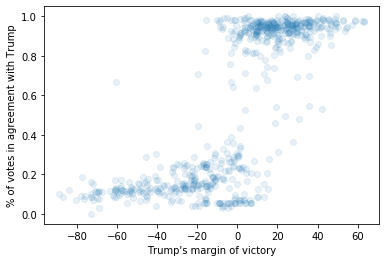

In [9]:
scatter(df_all)

Two clusters are apparent: it will come as no surprise that they represent the two parties.

I'll generate that plot again with the data points color-coded by party.

In [10]:
df_all['party'].value_counts()

Republican     339
Democrat       306
Independent      3
Name: party, dtype: int64

In [11]:
dem = (df_all['party'] == 'Democrat')
dem_all = df_all[dem]
len(dem_all)

306

In [12]:
rep = (df_all['party'] == 'Republican')
rep_all = df_all[rep]
len(rep_all)

339

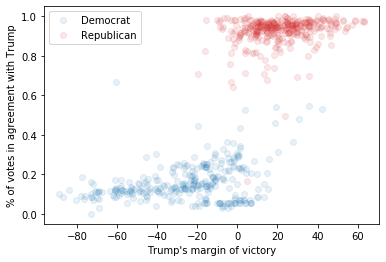

In [13]:
scatter(dem_all, color='C0', label='Democrat')
scatter(rep_all, color='C3', label='Republican')
plt.legend();

## Scatter log odds

Here's what the scatter plots look like on a log-odds scale.

In [14]:
def scatter2(df, **options):
    agree = df['agree_log_odds']
    margin = df['net_trump_vote']
    plt.plot(margin, agree, 'o', alpha=0.1, **options)

    plt.xlabel("Trump's margin of victory")
    plt.ylabel("Log odds in agreement with Trump")

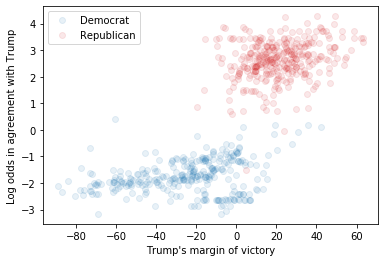

In [15]:
scatter2(dem_all, color='C0', label='Democrat')
scatter2(rep_all, color='C3', label='Republican')
plt.legend();

## Regression

Now let's see, within each party, what the relationship looks like between the margin of victory and the voting record.

In [16]:
model = smf.ols('agree_log_odds ~ net_trump_vote', data=dem_all)
results_dem = model.fit()
results_dem.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         agree_log_odds   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     27.66
Date:                Wed, 03 Jun 2020   Prob (F-statistic):           2.73e-07
Time:                        22:27:04   Log-Likelihood:                -285.88
No. Observations:                 306   AIC:                             575.8
Df Residuals:                     304   BIC:                             583.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.5457      0.050    -30.947      0.000      -1.644      -1.447
net_trump_vote     0.0074      0.001      5.260      0.000       0.005       0.010
==============================================================================
Omnibus:                        2.367   Durbin-Watson:                   1.122
Prob(Omnibus):                  0.306   Jarque-Bera (JB):                2.410
Skew:                           0.016   Prob(JB):                        0.300
Kurtosis:                       3.434   Cond. No.                         49.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
model = smf.ols('agree_log_odds ~ net_trump_vote', data=rep_all)
results_rep = model.fit()
results_rep.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         agree_log_odds   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     24.41
Date:                Wed, 03 Jun 2020   Prob (F-statistic):           1.23e-06
Time:                        22:27:04   Log-Likelihood:                -369.23
No. Observations:                 339   AIC:                             742.5
Df Residuals:                     337   BIC:                             750.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.3525      0.066     35.410      0.000       2.222       2.483
net_trump_vote     0.0126      0.003      4.941      0.000       0.008       0.018
==============================================================================
Omnibus:                       58.343   Durbin-Watson:                   1.867
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              140.684
Skew:                          -0.841   Prob(JB):                     2.82e-31
Kurtosis:                       5.670   Cond. No.                         44.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Prediction

To visualize the results of the models, I'll plot their predictions.

In [18]:
hypo = pd.DataFrame()
hypo['net_trump_vote'] = np.linspace(-80, 20)

pred_dem = results_dem.predict(hypo)
pred_dem.index = hypo['net_trump_vote']

In [19]:
hypo = pd.DataFrame()
hypo['net_trump_vote'] = np.linspace(-10, 70)

pred_rep = results_rep.predict(hypo)
pred_rep.index = hypo['net_trump_vote']

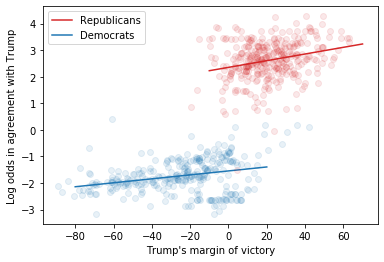

In [20]:
pred_rep.plot(color='C3', label='Republicans')
pred_dem.plot(color='C0', label='Democrats')

scatter2(dem_all, color='C0')
scatter2(rep_all, color='C3')

plt.legend();

It looks like the margin matters.

The slope for democrats is lower.

In [21]:
results_dem.params

Intercept        -1.545690
net_trump_vote    0.007447
dtype: float64

In [22]:
results_rep.params

Intercept         2.352523
net_trump_vote    0.012576
dtype: float64

It looks like it gets dragged down by a cluster of representatives from swing districts who vote against Trump with remarkable consistency.  Let's see who they are.

In [23]:
swing = (np.abs(dem_all['net_trump_vote']) < 8)

In [24]:
anti_trump = (dem_all['agree_log_odds'] < -2.5)

In [25]:
dem_all[swing & anti_trump]

,congress,chamber,bioguide,last_name,state,district,party,votes,agree_pct,predicted_agree,net_trump_vote,agree_log_odds
286,0,house,C001117,Casten,IL,6.0,Democrat,72.0,0.055556,0.120612,-7.0,-2.624669
290,0,house,C001119,Craig,MN,2.0,Democrat,72.0,0.055556,0.285124,1.2,-2.624669
371,0,house,D000629,Davids,KS,3.0,Democrat,72.0,0.055556,0.217135,-1.2,-2.624669
373,0,house,D000630,Delgado,NY,19.0,Democrat,72.0,0.055556,0.503497,6.8,-2.624669
570,0,house,H001066,Horsford,NV,4.0,Democrat,72.0,0.055556,0.146273,-4.9,-2.624669
597,0,house,H001081,Hayes,CT,5.0,Democrat,72.0,0.055556,0.158511,-4.1,-2.624669
606,0,house,H001087,Hill,CA,25.0,Democrat,51.0,0.039216,0.101966,-6.7,-2.813411
610,0,house,H001090,Harder,CA,10.0,Democrat,72.0,0.041667,0.177954,-3.0,-2.862201
667,0,house,K000368,Kirkpatrick,AZ,2.0,Democrat,64.0,0.031250,0.140082,-4.9,-3.044522
712,0,house,K000394,Kim,NJ,3.0,Democrat,72.0,0.055556,0.477804,6.2,-2.624669
